- Nom    :  GHOUL  
- Prenom : Branis  
- id     : 28612738  
- Master : ISI  

# Analyse des sentiments
Il s'agit d'un exemple d'analyse des sentiments développée au-dessus de l'ensemble de données IMDb. L'ensemble de données IMDb contient le texte de `50 000` critiques de films de l'Internet Movie Database. Chaque avis est positif ou négatif (0 ou 1). L'ensemble de données est divisé en `25 000` avis pour la formation et `25 000` avis pour les tests. Notre objectif est de construire un classificateur capable de prédire le jugement binaire compte tenu du texte. Nous pouvons facilement charger IMDb via `tf.keraset` les séquences de mots dans les revues ont été converties en séquences d'entiers, où chaque entier représente un mot spécifique dans un dictionnaire. Nous avons égalementun moyen pratique de remplir les phrases en `max_len`, afin que nous puissions utiliser toutes les phrases, qu'elles soient courtes ou longues, comme entrées d'un réseau de neurones avec un vecteur d'entrée de taille fixe.

In [7]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from attention import Attention
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 
import numpy as np

max_len = 100
num_words = 5000
dim_embedding = 128
EPOCHS = 10
BATCH_SIZE = 64

In [8]:
# Importation dela dataset
def load_data(num_words, max_len, truncating='post'):
        # Load data.
        (X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words=num_words,  maxlen=max_len)
        # Pad sequences with max_len.
        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len, truncating=truncating)
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len, truncating=truncating)
        return (X_train, y_train), (X_test, y_test)


# Fonctions utiles
def plot_history(history):
    plt.figure(figsize=(10, 5))
    # On trace l'évolution de l'accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy']) 
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # On trace l'évolution de la loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def pridiction(model, X_test, y_test, activation='sigmoid'):
    # On prédit sur les données de test
    y_hat = model.predict(X_test)

    # On tranforme les prédictions en labels
    y_pred = np.array(y_hat >= (0.5 if activation =='sigmoid' else 0)).astype(int)

    # On importe les librairies pour l'évaluation
    # On calcule la matrice de confusion
    cm_test = confusion_matrix(y_test, y_pred)
    print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')

    # On calcul le score d accuracy
    acc_train=accuracy_score(y_test, y_pred)
    print('L accuracy sur le jeu de test est :\n', acc_train)

In [9]:
(X_train, y_train), (X_test, y_test) = load_data(num_words, max_len, truncating='post')

# Simple RNN 
- dropout (avec un taux de 25% en sortie du RNN)
- activation $softmax()$

In [48]:
def build_SimpleRNN(num_words=5000, 
                    embed_size=128, 
                    RNN_size=64, 
                    loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics='accuracy'):
    # Example d'architecture pour le réseau RNN simple avec dropout
    model = Sequential()                                    
    model.add(Embedding(num_words, embed_size))                 # layer embedding
    model.add(SimpleRNN(RNN_size, return_sequences = False))    # layer RNN
    model.add(Dropout(0.25))                                    # layer Dropout
    model.add(Dense(1, activation='sigmoid'))                   # layer Dense

    # On affiche l'architecture de notre modèle
    model.summary()

    # On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    
    return model

In [49]:
SimpleRNN = build_SimpleRNN()
SimpleRNN.compile(  optimizer = "adam", loss = "binary_crossentropy",
                metrics = ["accuracy"]  )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 128)         640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________


In [50]:
history_SimpleRNN = SimpleRNN.fit(X_train, y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = (X_test, y_test),
                    validation_split = 0.2 )
                    
score_SimpleRNN = SimpleRNN.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

Epoch 1/10
44/44 [==============================] - 3s 37ms/step - loss: 0.6871 - accuracy: 0.5366 - val_loss: 0.6779 - val_accuracy: 0.5606
Epoch 2/10
44/44 [==============================] - 1s 34ms/step - loss: 0.4826 - accuracy: 0.8338 - val_loss: 0.6286 - val_accuracy: 0.6588
Epoch 3/10
44/44 [==============================] - 2s 44ms/step - loss: 0.1588 - accuracy: 0.9737 - val_loss: 0.6625 - val_accuracy: 0.6544
Epoch 4/10
44/44 [==============================] - 2s 46ms/step - loss: 0.0342 - accuracy: 0.9989 - val_loss: 0.6174 - val_accuracy: 0.7212
Epoch 5/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.6407 - val_accuracy: 0.7273
Epoch 6/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.6695 - val_accuracy: 0.7246
Epoch 7/10
44/44 [==============================] - 2s 39ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.7222
Epoch 8/10
44

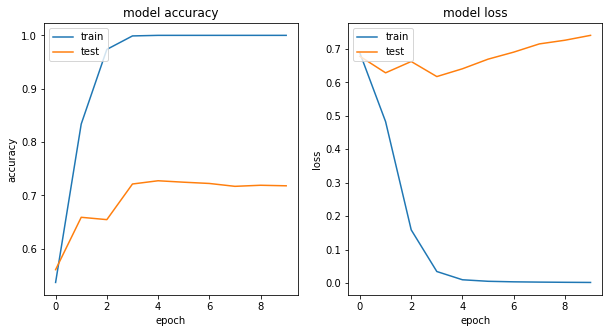

In [51]:
plot_history(history_SimpleRNN)

In [52]:
pridiction(SimpleRNN, X_test, y_test)

93/93 [==============================] - 1s 5ms/step
La matrice de confusion sur le jeu de test :
 [[ 901  458]
 [ 378 1226]] 

L accuracy sur le jeu de test est :
 0.7178535268309146


### Analyse : 
**- La LOSS:**   
    La perte de formation deminue à chaque époch, contrairement à la perte de validation elle augmente pour chaque époch, cela signifie que le réseau peut être en sur-ajustement. Les solutions à cela consistent par exemple à réduire la taille du réseau ou augmenter les données d'apprentissage (si possible) ou augmenter le dropout (0.35, 0.5, ... ainsi de suite).

**- L'accuracy:**  
    La précision de formation augmente pour chaque époch jusqu'à atteindre une valeur de 0.99, mais celle de la validation elle atteint son maximum à la première époch 0.79 et puis elle ne fait que oscillée autour de cette valeur. Cela peut être dû au pas d'apprentissage, qui peut être important.

### Remarque : 
Les réseaux de neurones récurrents simples (ou SimpleRNN) sont les premiers réseaux de neurones qui peuvent aider à analyser et à apprendre des séquences de données plutôt qu'un simple apprentissage basé sur des instances. Comme toutes les autres techniques de ML, elle présente certains inconvénients qui laissent la porte ouverte à l'amélioration. Premièrement, il ne parvient pas à stocker les informations pendant une période plus longue. Parfois, une référence à certaines informations stockées il y a assez longtemps est nécessaire pour prédire la sortie actuelle. Mais les RNN sont absolument incapables de gérer de telles «dépendances à long terme». Deuxième, il n'y a pas de contrôle plus fin sur quelle partie du contexte doit être reportée et quelle part du passé doit être « oubliée ». D'autres problèmes avec les RNN sont les gradients d'explosion et de disparition qui se produisent pendant le processus de formation d'un réseau par retour en arrière.

# RNN-LSTM gauche-droite classique
- dropout (avec un taux de 20% en sortie du LSTM)
- activation $sigmoid()$

In [53]:
def build_LSTM(     num_words=5000, 
                    embed_size=128, 
                    LSTM_size=64, 
                    loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics='accuracy'  ):
    
    # Example d'architecture pour le réseau RNN simple avec dropout
    model = Sequential()                                    
    model.add(Embedding(num_words, embed_size))                        # layer embedding
    model.add(LSTM(LSTM_size, dropout=0.2, recurrent_dropout=0.2))     # layer LSTM (dropout 0.2, reccurent_dropout=0.2)
    model.add(Dense(1, activation='sigmoid'))                          # layer Dense

    # On affiche l'architecture de notre modèle
    model.summary()

    # On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    
    return model

In [54]:
LSTM = build_LSTM()
LSTM.compile(  optimizer = "adam", loss = "binary_crossentropy",
                metrics = ["accuracy"]  )

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,473
Trainable params: 689,473
Non-trainable params: 0
_________________________________________________________________


In [55]:
history_LSTM =      LSTM.fit(   X_train, y_train,
                                epochs = EPOCHS,
                                batch_size = BATCH_SIZE,
                                # validation_data = (X_test, y_test),
                                validation_split=0.2,
                                verbose=1   )

Epoch 1/10
35/35 [==============================] - 6s 101ms/step - loss: 0.6710 - accuracy: 0.5595 - val_loss: 0.6180 - val_accuracy: 0.7441
Epoch 2/10
35/35 [==============================] - 4s 121ms/step - loss: 0.4844 - accuracy: 0.8354 - val_loss: 0.4329 - val_accuracy: 0.8234
Epoch 3/10
35/35 [==============================] - 8s 239ms/step - loss: 0.2730 - accuracy: 0.9067 - val_loss: 0.4100 - val_accuracy: 0.7946
Epoch 4/10
35/35 [==============================] - 5s 154ms/step - loss: 0.1857 - accuracy: 0.9391 - val_loss: 0.3581 - val_accuracy: 0.8432
Epoch 5/10
35/35 [==============================] - 5s 151ms/step - loss: 0.1017 - accuracy: 0.9693 - val_loss: 0.4157 - val_accuracy: 0.8234
Epoch 6/10
35/35 [==============================] - 8s 235ms/step - loss: 0.0669 - accuracy: 0.9815 - val_loss: 0.4299 - val_accuracy: 0.8216
Epoch 7/10
35/35 [==============================] - 5s 150ms/step - loss: 0.0452 - accuracy: 0.9910 - val_loss: 0.4979 - val_accuracy: 0.8378
Epoch 

In [56]:
score_LSTM = LSTM.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

47/47 [==============================] - 1s 28ms/step - loss: 0.7114 - accuracy: 0.8255


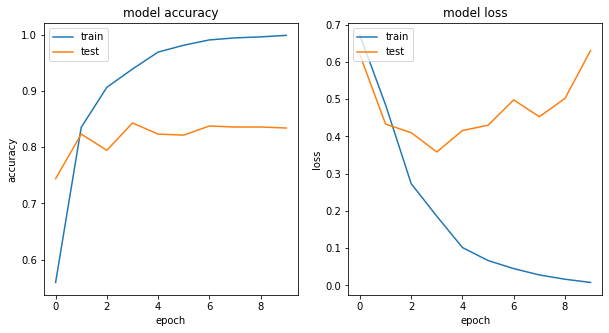

In [57]:
plot_history(history_LSTM)

In [58]:
pridiction(LSTM, X_test, y_test)

93/93 [==============================] - 1s 11ms/step
La matrice de confusion sur le jeu de test :
 [[1117  242]
 [ 275 1329]] 

L accuracy sur le jeu de test est :
 0.8255146810664866


### Analyse : 
**- La LOSS:**   
    La perte de formation est toujour bien inférieure à la perte de validation, ce qui n'est pas du tous bon signe pour un apretissage!!

**- L'accuracy:**  
    N'est au moins cette fois ci la précision augmente jusqu'a atteindre la valeur de 0.82. n'empêche que notre modèle rentre sur apprentissage. 

### Remarque :
Les réseaux LSTM sont une extension des réseaux de neurones récurrents (RNN) principalement introduits pour gérer les situations où les RNN échouent. Ainsi, la mémoire longue à court terme (LSTM) a été conçu de manière à ce que le problème du gradient de fuite soit presque complètement supprimé, tandis que le modèle d'apprentissage reste inchangé. Les longs retards dans certains problèmes sont comblés à l'aide de LSTM où ils gèrent également le bruit, les représentations distribuées et les valeurs continues. Avec les LSTM, il n'est pas nécessaire de conserver un nombre fini d'états à l'avance comme l'exige le modèle de Markov caché (HMM). Les LSTM nous fournissent une large gamme de paramètres tels que les taux d'apprentissage et les biais d'entrée et de sortie. Par conséquent, aucun réglage fin n'est nécessaire. La complexité pour mettre à jour chaque poids est réduite à O (1) avec les LSTM, similaire à celle de la rétropropagation dans le temps (BPTT), ce qui est un avantage. 

# LSTM bi-directionnel et return_sequences = False
- dropout (avec un taux de 20% en sortie du RNN)
- activation $sigmoid()$

In [69]:
def build_LSTM_bi_directionnel( num_words=5000, 
                                embed_size=128, 
                                LSTM_size=64, 
                                loss='binary_crossentropy', 
                                optimizer='adam', 
                                metrics='accuracy'  ):
    
    # Example d'architecture pour le réseau RNN simple avec dropout
    model = Sequential()                                    
    model.add(Embedding(num_words, embed_size))                                       # layer embedding
    model.add(Bidirectional(LSTM(LSTM_size, dropout=0.2, recurrent_dropout=0.2)))     # layer LSTM
    model.add(Dropout(0.25))                                                          # layer Dropout

    model.add(Dense(1, activation='sigmoid'))                                         # layer Dense

    # On affiche l'architecture de notre modèle
    model.summary()

    # On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    
    return model

In [70]:
LSTM_bi_directionnel = build_LSTM_bi_directionnel()
LSTM_bi_directionnel.compile(  optimizer = "adam", loss = "binary_crossentropy",
                metrics = ["accuracy"]  )

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         640000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [76]:
history_LSTM_bi_directionnel = LSTM_bi_directionnel.fit(  X_train, y_train,
                                                          epochs = EPOCHS,
                                                          batch_size = BATCH_SIZE,
                                                        #   validation_data = (X_test, y_test) 
                                                          validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 9s 256ms/step - loss: 5.9097e-04 - accuracy: 1.0000 - val_loss: 0.9927 - val_accuracy: 0.8252
Epoch 2/10
35/35 [==============================] - 11s 303ms/step - loss: 7.7977e-04 - accuracy: 1.0000 - val_loss: 0.8087 - val_accuracy: 0.8270
Epoch 3/10
35/35 [==============================] - 12s 333ms/step - loss: 5.4975e-04 - accuracy: 1.0000 - val_loss: 0.9675 - val_accuracy: 0.8216
Epoch 4/10
35/35 [==============================] - 12s 332ms/step - loss: 3.9927e-04 - accuracy: 1.0000 - val_loss: 1.0147 - val_accuracy: 0.8252
Epoch 5/10
35/35 [==============================] - 11s 324ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 1.0445 - val_accuracy: 0.8342
Epoch 6/10
35/35 [==============================] - 12s 335ms/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 0.5331 - val_accuracy: 0.8054
Epoch 7/10
35/35 [==============================] - 12s 340ms/step - loss: 0.0412 - accuracy: 0.9851 - val_loss: 0.5767 - val_a

In [77]:
score_LSTM_bi_directionnel = LSTM_bi_directionnel.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

47/47 [==============================] - 1s 26ms/step - loss: 0.8305 - accuracy: 0.8205


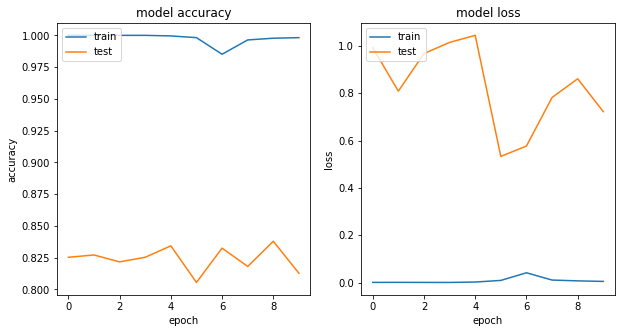

In [78]:
plot_history(history_LSTM_bi_directionnel)

### Analyse : 
**- La LOSS:**   
    On analysant le comportement de notre modèle lors de l'apprentissage et la validation, on comprend très vite que les LSTM bi directionnel ne sont pas les mieux adaptés à notre application (analyse de sentiments). Comme nous l'avons mentionné ci dessue les LSTM sont adaptés à des applications ou nos valeurs dépendes du future (exemple : la traduction). Par conséquent, ce n'est pas le cas pour l'analyse de sentiment. Ce qui explique la dégradation de la précision par rapport au LSTM simple.
     
**- L'accuracy:**  
    Sans aucune surprise! le modèle oscille autour d'une valeur et n'arrive pas à s'améliorer

### Remarque:
Un état typique dans un RNN (RNN simple, GRU ou LSTM) repose sur les événements passés et présents. Un état au temps $t$ dépend des états `x1, x2,…,xt−1x1,x2,…,xt−1`, et `xtxt`. C'est le cas idéaliste, mais parfois nos valeurs dépendent du passé, du présent et du futur. Les LSTM bidirectionnels sont une extension des LSTM traditionnels qui peuvent améliorer les performances du modèle sur les problèmes de classification de séquences. Dans les problèmes où tous les pas de temps de la séquence d'entrée sont disponibles, les LSTM bidirectionnels entraînent deux LSTM au lieu d'un sur la séquence d'entrée. Le premier sur la séquence d'entrée telle quelle et le second sur une copie inversée de la séquence d'entrée. Cela peut fournir un contexte supplémentaire au réseau et entraîner un apprentissage plus complet du problème.

# 4- LSTM mecanisme d'attention

In [12]:
def build_LSTM_attention(   num_words=5000, 
                            embed_size=128, 
                            LSTM_size=64, 
                            loss='binary_crossentropy', 
                            optimizer='adam', 
                            metrics='accuracy'  ):
    
    # Example d'architecture pour le réseau RNN simple avec dropout
    model = Sequential()                                    
    model.add(Embedding(num_words, embed_size))                                       # layer embedding
    model.add(Bidirectional(LSTM(LSTM_size, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))     # layer LSTM
    model.add(Attention(32))

    model.add(Dense(1, activation='sigmoid'))                                         # layer Dense

    # On affiche l'architecture de notre modèle
    model.summary()

    # On spécifie la fonction de perte, l'optimiseur, et la fonction d'évaluation
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    
    return model

In [13]:
LSTM_attention = build_LSTM_attention()
LSTM_attention.compile(  optimizer = "adam", loss = "binary_crossentropy",
                metrics = ["accuracy"]  )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 attention_2 (Attention)     (None, 32)                24576     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 763,425
Trainable params: 763,425
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_LSTM_attention = LSTM_attention.fit(  X_train, y_train,
                                              epochs = EPOCHS,
                                              batch_size = BATCH_SIZE,
                                            #   validation_data = (X_test, y_test) 
                                                validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 15s 289ms/step - loss: 0.6771 - accuracy: 0.5546 - val_loss: 0.6220 - val_accuracy: 0.7027
Epoch 2/10
35/35 [==============================] - 10s 298ms/step - loss: 0.3635 - accuracy: 0.8503 - val_loss: 0.3469 - val_accuracy: 0.8450
Epoch 3/10
35/35 [==============================] - 15s 421ms/step - loss: 0.1367 - accuracy: 0.9495 - val_loss: 0.3518 - val_accuracy: 0.8541
Epoch 4/10
35/35 [==============================] - 14s 412ms/step - loss: 0.0858 - accuracy: 0.9748 - val_loss: 0.3179 - val_accuracy: 0.8631
Epoch 5/10
35/35 [==============================] - 16s 434ms/step - loss: 0.0624 - accuracy: 0.9842 - val_loss: 0.3648 - val_accuracy: 0.8577
Epoch 6/10
35/35 [==============================] - 13s 359ms/step - loss: 0.0176 - accuracy: 0.9959 - val_loss: 0.4579 - val_accuracy: 0.8396
Epoch 7/10
35/35 [==============================] - 13s 362ms/step - loss: 0.0080 - accuracy: 0.9986 - val_loss: 0.5557 - val_accuracy: 0.8486

In [15]:
score_LSTM_attention = LSTM_attention.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

47/47 [==============================] - 1s 27ms/step - loss: 0.8655 - accuracy: 0.8309


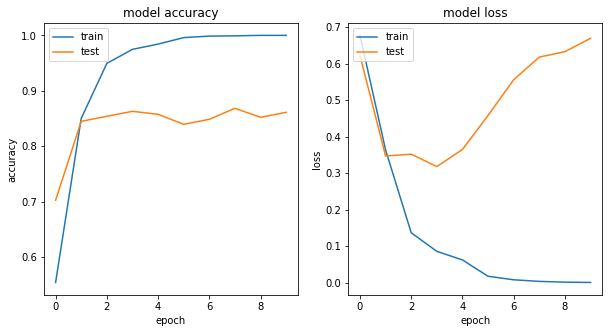

In [16]:
plot_history(history_LSTM_attention)

### Analyse :  

    avec le mécanisme d'attention on arrive à 86% de précision ce qui est pas mal !! malgré que l'on a toujours un surapprentissage, mais la loss de ce dernier et meilleur que les LSTM bi directionnel, LSTM simple et RNN.
     

### Remarque:
Dans une couche RNN avec Attention, on a aussi ce calcul récurrent sur chaque mot. Mais en plus de cela, on garde chacune de ces sorties récurrentes en mémoire pour former la sortie finale. Dit autrement, l'Encodeur de l'Attention va transmettre beaucoup plus d'informations au Décodeur que lors de l'approche classique.